In [1]:
%reload_ext autoreload
%autoreload 2


# Make a simple atom

In [2]:
from atomphys.quantum_numbers import QuantumNumbers

QuantumNumbers.from_term("1D2")

QuantumNumbers(J=2, L=2, S=0, parity=1)

In [3]:
from math import pi
from atomphys import State, Transition, Atom
from pint import get_application_registry

from atomphys.plot import plot_atom


ureg = get_application_registry()

# ------- two levels

s_s = State(configuration='1s', term="1S0", energy=0)
s_p = State('2p', '1P1', energy=ureg('400 nm').to('Ry'))

tr_sp = Transition(state_i=s_s, state_f=s_p, A=1 / ureg('1 ns') / 2 / pi)

a2 = Atom('Simple_two_levels')
a2.add_states([s_s, s_p])
a2.add_transition(tr_sp)

del s_s, s_p, tr_sp

# ------- three levels
# I cannot recycle states otherwise it would overwrite their ._atom

s_s = State(configuration='1s', term="1S0", energy=0)
s_p = State('2p', '1P1', energy=ureg('400 nm').to('Ry'))
s_d = State('3d', '1D2', energy=ureg('600 nm').to('Ry'))

tr_sp = Transition(state_i=s_s, state_f=s_p, A=1 / ureg('1 ns') / 2 / pi)
tr_sd = Transition(s_s, s_d, A=1 / ureg('1 s') / 2 / pi)
tr_dp = Transition(s_d, s_p, A=1 / ureg('10 ns') / 2 / pi)

a3 = Atom('Simple_three_levels')
a3.add_states([s_s, s_p, s_d])
a3.add_transitions([tr_sp, tr_sd, tr_dp])

del s_s, s_p, s_d, tr_sp, tr_sd, tr_dp


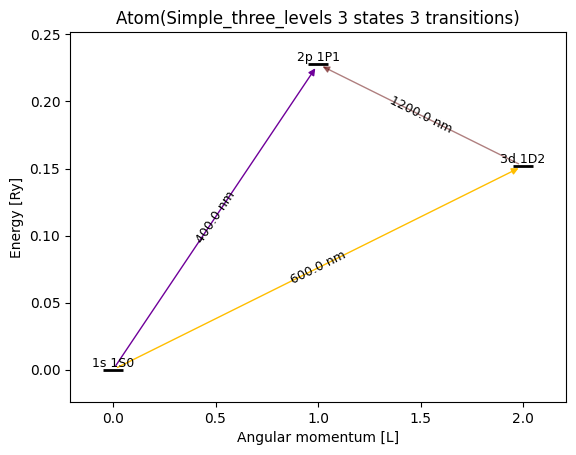

In [4]:
plot_atom(a3)

In [5]:
a2.states[0] == a3.states[0], a2.states[0] is a3.states[0]

(True, False)

# Make hamiltonians

In [6]:
from atomphys.calc import Hamiltonians as hat
from atomphys.electric_field import LaserField
import pint
import qutip
import numpy as np
import matplotlib.pyplot as plt

ureg = pint.get_application_registry()
ureg.default_format = ".4f~P"


## Decay of excited state

In [7]:
atom = a3

kets = hat.kets(atom, atom.states)
H0 = hat.H0(atom, atom.states, None)
c_ops = hat.collapse_operators(atom, atom.states, atom._ureg, print_added_operators=True)

# projectors = {ss: ket * ket.dag() for ss, ket in kets.items()}
projectors = {}
for s in atom.states:
    proj = sum([ket * ket.dag() for (_s, _), ket in kets.items() if _s == s])
    projectors[s] = proj
    
e_ops = list(projectors.values())


Added 1.59×10⁻⁷+0j MHz c operator from ('1D2', -2.0) to ('1S0', 0.0)
Added 1.59×10⁻⁷+0j MHz c operator from ('1D2', -1.0) to ('1S0', 0.0)
Added 1.59×10⁻⁷+0j MHz c operator from ('1D2', 0.0) to ('1S0', 0.0)
Added 1.59×10⁻⁷+0j MHz c operator from ('1D2', 1.0) to ('1S0', 0.0)
Added 1.59×10⁻⁷+0j MHz c operator from ('1D2', 2.0) to ('1S0', 0.0)
Added 159+0j MHz c operator from ('1P1', -1.0) to ('1S0', 0.0)
Added 159+0j MHz c operator from ('1P1', 0.0) to ('1S0', 0.0)
Added 159+0j MHz c operator from ('1P1', 1.0) to ('1S0', 0.0)
Added 9.55+0j MHz c operator from ('1P1', -1.0) to ('1D2', -2.0)
Added 0+0j MHz c operator from ('1P1', 0.0) to ('1D2', -2.0)
Added 0+0j MHz c operator from ('1P1', 1.0) to ('1D2', -2.0)
Added 4.77+0j MHz c operator from ('1P1', -1.0) to ('1D2', -1.0)
Added 4.77+0j MHz c operator from ('1P1', 0.0) to ('1D2', -1.0)
Added 0+0j MHz c operator from ('1P1', 1.0) to ('1D2', -1.0)
Added 1.59+0j MHz c operator from ('1P1', -1.0) to ('1D2', 0.0)
Added 6.37+0j MHz c operator f

In [8]:
H0

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 3.13941928e+09 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.13941928e+09 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13941928e+09
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.13941928e+09 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.13941928e+09 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

In [22]:
psi0 = kets[(atom.get_state("P"), -1)]
t = np.arange(0, 0.1, 0.0005)

sol = qutip.mesolve(H0, psi0, t, c_ops, e_ops, progress_bar=True)


10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.00s. Est. time left: 00:00:00:00
40.0%. Run time:   0.00s. Est. time left: 00:00:00:00
50.0%. Run time:   0.00s. Est. time left: 00:00:00:00
60.0%. Run time:   0.00s. Est. time left: 00:00:00:00
70.0%. Run time:   0.01s. Est. time left: 00:00:00:00
80.0%. Run time:   0.01s. Est. time left: 00:00:00:00
90.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.01s


In [23]:
# populations = {k: np.real(np.diag(s)) for k, s in zip(kets.keys(), sol.states)}
populations = np.asarray(sol.expect).T
populations.shape


(200, 3)

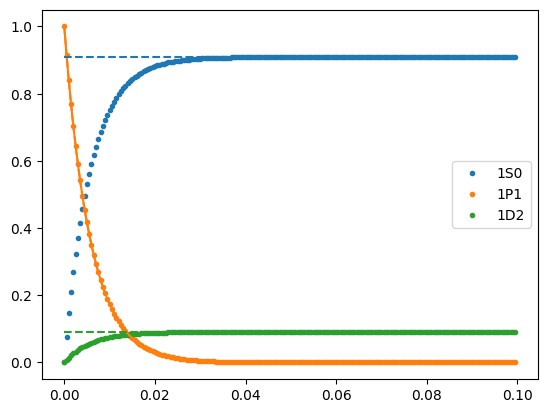

In [24]:
# ------- fit decay and check final populations

from scipy.optimize import curve_fit


def decay(t, tau):
    return np.exp(-t / tau)


expected_tau = 1 / atom.get_state('P').Gamma


p, cov = curve_fit(decay, t, populations[:, 1], (1,))
fitted_tau = p[0] * ureg.us

fig, ax = plt.subplots()
ax.plot(t, populations, 'o', ms=3, label=[s.term for s in projectors.keys()])
ax.plot(t, decay(t, *p), 'C1')
ax.plot(t, decay(t, expected_tau.to('us').m), 'C1--')

ax.hlines(atom.get_state('P').decay_branching_ratios.values(), t[0], t[-1], color=['C0', 'C2'], ls='--')
ax.legend()

In [12]:


print(expected_tau.to('ns'))
print(fitted_tau.to('ns'))


5.7120 ns
5.7120 ns


In [13]:
populations[-1]

array([ 9.09090923e-01, -9.32121138e-09,  9.09090861e-02])

In [14]:
atom.states[1].Gamma.to('MHz')

175.0704374010848 <Unit('megahertz')>

In [15]:
atom.states

[State(1s 1S0 0 Ry), State(2p 1P1 0.2278 Ry), State(3d 1D2 0.1519 Ry)]

# Rabi oscilations

In [128]:
# eps = (1, 1j, 0)
# e_z = (0, 0, 1)
eps = (0, 0, 1)
e_z = (1, 0, 0)
# P = 1 * ureg('uW')
# waist = 50 * ureg('um')
# I0 = 2 * P / (np.pi * waist**2)

atom = a2
tr = atom.transitions[0]
I0 = tr.saturation_intensity

laser = LaserField(polarization=eps, direction_of_propagation=e_z, wavelength=tr.wavelength, intensity=I0, detuning=0)

lasers = {laser: [tr]}
states = atom.states
kets = hat.kets(atom, states)
H = hat.H0(atom, states, None) + hat.H_int(atom, states, lasers, None)
projectors = {ss: ket * ket.dag() for ss, ket in kets.items()}
e_ops = list(projectors.values())


H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.00000000e+00 0.00000000e+00 5.62697698e+01 0.00000000e+00]
 [0.00000000e+00 9.53674316e-07 0.00000000e+00 0.00000000e+00]
 [5.62697698e+01 0.00000000e+00 9.53674316e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.53674316e-07]]

In [132]:
psi0 = kets[(atom.get_state("S"), 0)]
t = np.arange(0, 0.2, 0.002)

sol = qutip.mesolve(H, psi0, t, c_ops=None, e_ops=e_ops, progress_bar=True)


10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.01s. Est. time left: 00:00:00:00
60.0%. Run time:   0.01s. Est. time left: 00:00:00:00
70.0%. Run time:   0.01s. Est. time left: 00:00:00:00
80.0%. Run time:   0.02s. Est. time left: 00:00:00:00
90.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s


In [133]:
populations = np.asarray(sol.expect).T
populations.shape


(100, 4)

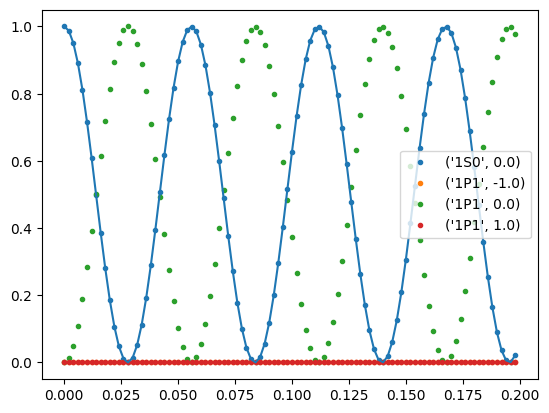

In [135]:
# ------- fit flop

from scipy.optimize import curve_fit


def flop(t, rabi_freq):
    return 0.5 + 0.5 * np.cos(2*np.pi*rabi_freq*t)



p, cov = curve_fit(flop, t, populations[:, 0], (15,))
fitted_rabi_freq = p[0] * ureg('MHz')

fig, ax = plt.subplots()
ax.plot(t, populations, 'o', ms=3, label=[(s.term, m) for s, m in projectors.keys()])
ax.plot(t, flop(t, *p), 'C0')

ax.legend()

In [138]:
calculated_rabi_freq = abs(float(Rabi_Frequency(laser, tr, mJ_i=0, mJ_f=0).to("MHz").m)) * ureg("MHz") / 2 / pi
calculated_rabi_freq

17.911224007836125 <Unit('megahertz')>

In [144]:
expected_rabi_freq_isat = tr.Gamma.to("MHz") / np.sqrt(2) / 2 / pi
expected_rabi_freq_isat


17.911224007836125 <Unit('megahertz')>

In [139]:
fitted_rabi_freq

17.91119897481327 <Unit('megahertz')>